# Lab 1: image rectification

This lab has two main goals:

1) Get more familiar with the hierarchy of 2D transformation <br>

2) Remove the projective distortion of an image of a planar object (image rectification)

The following file combines some text cells (Markdown cells) and code cells. Some parts of the code need to be completed. All tasks you need to complete are marked in <span style='color:Green'> green.  </span>

In [ ]:
from PIL import Image, ImageDraw
import numpy as np
from scipy.ndimage import map_coordinates
from numpy import linalg as LA
from math import ceil
from utils import line_draw, plot_img

## **1. Applying image transformations**

In this first part of the lab you will apply different types of 2D transformations to a given image. For that, you first need to create a function that applies a homography to animage.

<span style='color:Green'> - Create the function  *apply_H* that gets as input a homography and
an image and returns the image transformed by the homography. </span>

Note: The size of the transformed image has to be automatically set so as to 
contain the whole transformed image.
You will need to interpolate the image values at some points, for that,
you may use the function *scipy.ndimage.map_coordinates*

In [ ]:
def transform_and_covert_to_inhomogeneous(H, coords):
  """ Transform a given set of points 'coords' by applying an homography H.

  - H (np.ndarray): Homography with shape (3, 3)
  - coords (np.ndarray): Set of points with shape (n, 3) in homogeneous coordinates

  Returns: Transformed points (n, 3)
  """
  new_coords = np.matmul(H, coords.reshape(-1, 3).transpose(1, 0)).transpose(1, 0)
  new_coords_inhomog = (new_coords[:,[0,1]]/new_coords[:,2, np.newaxis]).transpose(1, 0)
  return new_coords_inhomog

def get_inhomogeneous_coordinates_inverse_mapping(img, H, map_corners=True, size_final_image=None, img_corners=None):
  """ Obtains the coordinates of the original image that are mapped from the transformed image with an inverse warping H^-1.

  - img (np.ndarray): Original image with shape (n, m)
  - H (np.ndarray): Homography with shape (3, 3)
  - map_corners (bool): Whether to map corners from the original image into the destination image. If this is set to False and 'size_final_image' is not
      specified, then the size of the original image will be used.
  - size_final_image (List [min_x, max_x, min_y, max_y]): Dimensions of the transformed image, this can be specified for debugging purposes.
  - img_corners (np.ndarray): Set of points representing the corners of the original image 'img' with shape (4, 3) in homogeneous coordinates. If specified, 
      they will be used for obtaining the dimensions of the transformed image.

  Returns: (Mapped coordinates, new height of transformed image, new width of transformed image, minimum x of transformed image, 
              minimum x of transformed image, mapped corners in the transformed image)
  """

  h, w, _ = img.shape

  if size_final_image is None:
    if map_corners:
      if img_corners is None:
        corners = np.array([[0, 0, 1], [w-1, 0, 1], [0, h-1, 1], [w-1, h-1, 1]])
      else:
        corners = img_corners
      corners_transformed = transform_and_covert_to_inhomogeneous(H, corners)

      min_x, max_x = int(np.min(corners_transformed[0])), int(np.max(corners_transformed[0]))
      min_y, max_y = int(np.min(corners_transformed[1])), int(np.max(corners_transformed[1]))
      new_h, new_w = int(max_y - min_y + 1), int(max_x - min_x + 1)
      corners_transformed = np.hstack([corners_transformed.transpose(1, 0), np.ones((corners_transformed.shape[1],1))])
      corners_transformed[:, 0] -= min_x
      corners_transformed[:, 1] -= min_y
    else:
      min_x, min_y = 0, 0
      new_h, new_w = h, w
      corners_transformed = np.array([[0, 0, 1], [w-1, 0, 1], [0, h-1, 1], [w-1, h-1, 1]])
  else:
    min_x, max_x, min_y, max_y = size_final_image
    new_h, new_w = max_y-min_y, max_x-min_x
    corners_transformed = np.array([[0, 0, 1], [w-1, 0, 1], [0, h-1, 1], [w-1, h-1, 1]])

  # Create all homogeneous coordinates combinations to later perform the inverse warping
  yv, xv = np.meshgrid(np.arange(new_h)+min_y, np.arange(new_w)+min_x)
  yv, xv = yv.transpose(1, 0), xv.transpose(1, 0)
  zv = np.ones_like(xv)
  coords = np.concatenate([xv[:,:,np.newaxis], yv[:,:,np.newaxis], zv[:,:,np.newaxis]], 2)

  # Compute inhomogoneous coordinates of the points where the coordinates map in the original image
  H_inv = np.linalg.inv(H)
  new_coords_inhomog = transform_and_covert_to_inhomogeneous(H_inv, coords)

  # We need to swap x and y, as the map_coordinates method addresses numpy arrays by row and column
  cp_ = new_coords_inhomog[1, :].copy()
  new_coords_inhomog[1, :] = new_coords_inhomog[0, :]
  new_coords_inhomog[0, :] = cp_

  return new_coords_inhomog, new_h, new_w, min_x, min_y, corners_transformed

def get_values_transformed_image(img, new_coords_inhomog, new_h, new_w):
  """
  Obtains the coordinates of the original image that are mapped from the transformed image with an inverse warping H^-1.

  - img (np.ndarray): Original image with shape (n, m)
  - new_coords_inhomog (np.ndarray): Inversely warped images from the transformed image into the original one of shape (n, 3).
  - new_h, new_w: Integers denoting the size of the transformed image.

  Returns: Transformed image of shape (new_h, new_w)
  """
  # Obtain values for new image
  new_values_img = []
  for i in range(3):
    new_values_img.append(map_coordinates(img[:,:,i], new_coords_inhomog, order=1, \
                                          mode="constant", cval=0).reshape(new_h, new_w)[:, :, np.newaxis])

  new_img = np.concatenate(new_values_img, 2)
  return new_img

def apply_H(img, H, map_corners=True, return_min_coordinates=False, size_final_image=None, img_corners=None):
  """ Obtains the coordinates of the original image that are mapped from the transformed image with an inverse warping H^-1.

  - img (np.ndarray): Original image with shape (n, m)
  - H (np.ndarray): Homography with shape (3, 3)
  - map_corners (bool): Whether to map corners from the original image into the destination image. If this is set to False and 'size_final_image' is not
      specified, then the size of the original image will be used.
  - return_min_coordinates (bool): Whether to return minimum coordinates of the transformed image.
  - size_final_image (List [min_x, max_x, min_y, max_y]): Dimensions of the transformed image, this can be specified for debugging purposes.
  - img_corners (np.ndarray): Set of points representing the corners of the original image 'img' with shape (4, 3) in homogeneous coordinates. If specified, 
      they will be used for obtaining the dimensions of the transformed image.

  Returns: Transformed image
      if return_min_coordinates is set to True, it also returns the transformed corners with shape (4, 3) and (min_x, min_y) of the transformed image.
  """
  new_coords_inhomog, new_h, new_w, min_x, min_y, corners_transformed = get_inhomogeneous_coordinates_inverse_mapping(img, H, map_corners, size_final_image, img_corners=img_corners)
  new_img = get_values_transformed_image(img, new_coords_inhomog, new_h, new_w)
  
  if return_min_coordinates:
    return new_img, corners_transformed, (min_x, min_y)
  else:
    return new_img

### **1.1 Similarities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a similarity transformation. </span>

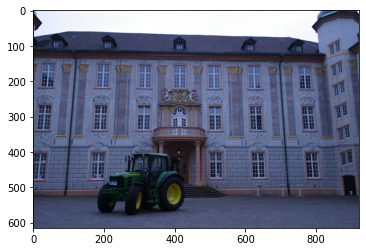

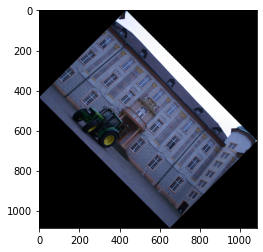

In [ ]:
def create_similarity_transformation(scale, alpha, translation):
  """
  Create a similarity matrix with the given scale, angle alpha and translation vector.
  """
  assert scale > 1e-5
  H = np.array([
        [scale*np.cos(alpha), -scale*np.sin(alpha), translation[0]],
        [scale*np.sin(alpha), scale*np.cos(alpha), translation[1]],
        [0, 0, 1]
  ])
  return H

theta = np.pi/4
s = 1
H= create_similarity_transformation(s, theta, [200, 200])

img_path = "./Data/0005_s.png"
I = Image.open(img_path)
I_sim = apply_H(np.array(I), H, map_corners=True)

plot_img(I)
plot_img(I_sim)

### **1.2 Affinities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces an affine transformation.  </span>

<span style='color:Green'> - Decompose the affinity in four transformations: two
rotations, a scale, and a translation (you may use function *numpy.linalg.svd* for that).  </span>

<span style='color:Green'> - Verify that the product of the four previous transformations
produces the same matrix H as above.  </span>

<span style='color:Green'> - verify that the proper sequence of the four previous
transformations over the image I produces the same transformed image as before.  </span>

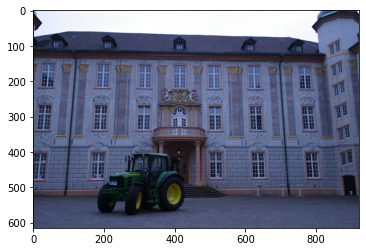

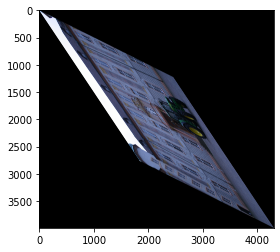

In [ ]:

def create_affine_transformation(affine_matrix, translation):
  """
  Create a similarity matrix with the given scale, angle alpha and translation vector.
  """

  H = np.array([
        [affine_matrix[0][0], affine_matrix[0][1], translation[0]],
        [affine_matrix[1][0], affine_matrix[1][1], translation[1]],
        [0, 0, 1]
  ])
  return H

translation = [0,0]
affine_matrix=np.array([
                [2,4],
                [3,2]
              ])

if ((affine_matrix[0][0]*affine_matrix[1][1]) - (affine_matrix[0][1]*affine_matrix[1][0])) == 0:
  print(affine_matrix)
  print('affine matrix must be non singular, determinant !=0')

H = create_affine_transformation(affine_matrix, translation)

img_path = "./Data/0005_s.png"
I = Image.open(img_path)

I_aff = apply_H(np.array(I), H)

plot_img(I)
plot_img(I_aff)

#### Decomposition of affinity matrix

![alt text](img_utils/affinity_matrix.PNG "Title")

In [ ]:
svd_output = np.linalg.svd(affine_matrix)
svd_output

(array([[-0.78820544, -0.61541221],
        [-0.61541221,  0.78820544]]),
 array([5.56155281, 1.43844719]),
 array([[-0.61541221, -0.78820544],
        [ 0.78820544, -0.61541221]]))

##### D matrix that is responsible for scaling

In [ ]:
D_matrix = svd_output[1]
D_matrix = np.array([
    [D_matrix[0], 0],
    [0, D_matrix[1]]
])
D_matrix

array([[5.56155281, 0.        ],
       [0.        , 1.43844719]])

##### First rotation matrix which is UV^t

In [ ]:
first_rotation = np.dot(svd_output[0],svd_output[2])
first_rotation

array([[-1.45543649e-16,  1.00000000e+00],
       [ 1.00000000e+00, -9.00324979e-17]])

##### Second rotation matrix V^t and V

In [ ]:
second_rotation_Vt = svd_output[2]
second_rotation_V = second_rotation_Vt.transpose()
print(f"V transposed as in image =\n {second_rotation_Vt}")
print(f"V as in image =\n {second_rotation_V}")

V transposed as in image =
 [[-0.61541221 -0.78820544]
 [ 0.78820544 -0.61541221]]
V as in image =
 [[-0.61541221  0.78820544]
 [-0.78820544 -0.61541221]]


#### Product of above decomposed matrix produce same A matrix

![alt text](img_utils/affinity_matrix_2.PNG "Title")

In [ ]:
first_rotation

array([[-1.45543649e-16,  1.00000000e+00],
       [ 1.00000000e+00, -9.00324979e-17]])

In [ ]:
r_minus_phi_D = np.dot(second_rotation_V,D_matrix)
r_minus_phi_D

array([[-3.4226475 ,  1.1337919 ],
       [-4.38364617, -0.88523796]])

In [ ]:
full_second_rotation = np.dot(r_minus_phi_D,second_rotation_Vt)
full_second_rotation

array([[3., 2.],
       [2., 4.]])

#### After all multiplications we get

In [ ]:
np.dot(first_rotation,full_second_rotation)

array([[2., 4.],
       [3., 2.]])

#### Comparing with affine matrix shows we get the same matrix A

In [ ]:
affine_matrix

array([[2, 4],
       [3, 2]])

### Comparing Image transformation step by step

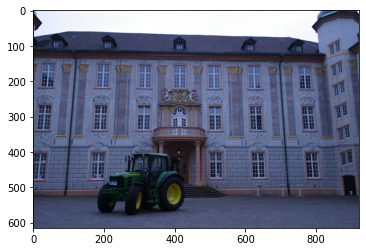

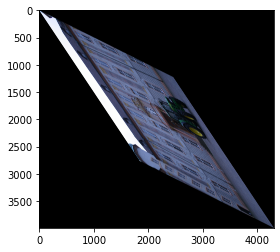

In [ ]:
img_path = "./Data/0005_s.png"
I = Image.open(img_path)

I_aff = apply_H(np.array(I), H)

plot_img(I)
plot_img(I_aff)

#### Step 1 

[[-0.61541221 -0.78820544]
 [ 0.78820544 -0.61541221]]


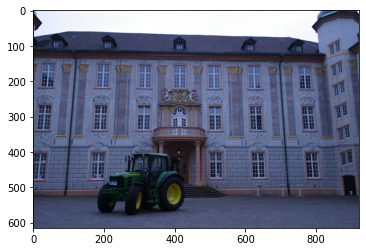

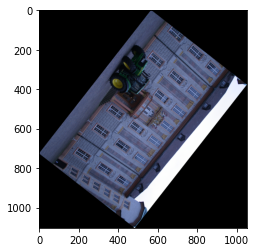

In [ ]:
print(second_rotation_Vt)
H = create_affine_transformation(second_rotation_Vt, [0,0])

I_aff_step1, corners_transformed, (min_x, min_y) = apply_H(np.array(I), H, return_min_coordinates=True)

plot_img(I)
plot_img(I_aff_step1)


#### Step 2

[[5.56155281 0.        ]
 [0.         1.43844719]]


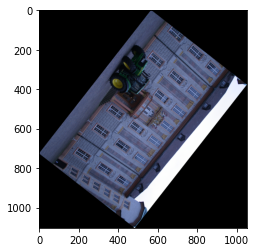

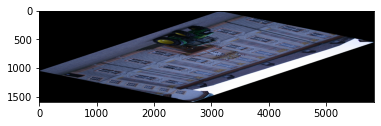

In [ ]:
print(D_matrix)
H= create_affine_transformation(D_matrix,[0,0])

I_aff_step2, corners_transformed, (min_x, min_y) = apply_H(np.array(I_aff_step1), H, return_min_coordinates=True, img_corners=corners_transformed)

plot_img(I_aff_step1)
plot_img(I_aff_step2)

In [ ]:
corners_transformed, min_x,min_y

(array([[ 5.84363045e+03,  5.43294590e+02,  1.00000000e+00],
        [ 2.69137210e+03,  1.58751693e+03,  1.00000000e+00],
        [ 3.15207170e+03, -2.41518838e-01,  1.00000000e+00],
        [-1.86646870e-01,  1.04398082e+03,  1.00000000e+00]]),
 -4,
 -1)

In [ ]:
I_aff_step2.shape

(1588, 5844, 3)

In [ ]:
corners_transformed, (min_x, min_y)

(array([[ 5.84363045e+03,  5.43294590e+02,  1.00000000e+00],
        [ 2.69137210e+03,  1.58751693e+03,  1.00000000e+00],
        [ 3.15207170e+03, -2.41518838e-01,  1.00000000e+00],
        [-1.86646870e-01,  1.04398082e+03,  1.00000000e+00]]),
 (-4, -1))

#### Step 3

[[-0.61541221  0.78820544]
 [-0.78820544 -0.61541221]]


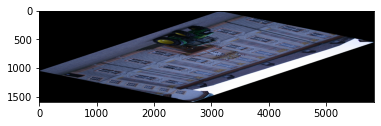

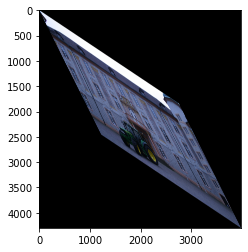

In [ ]:
print(second_rotation_V)
H= create_affine_transformation(second_rotation_V,[0,0])

I_aff_step3, corners_transformed, (min_x, min_y) = apply_H(np.array(I_aff_step2), H, return_min_coordinates=True, img_corners=corners_transformed)

plot_img(I_aff_step2)
plot_img(I_aff_step3)

In [ ]:
contours =  I_aff_step3

#### Step 4

[[-1.45543649e-16  1.00000000e+00]
 [ 1.00000000e+00 -9.00324979e-17]]


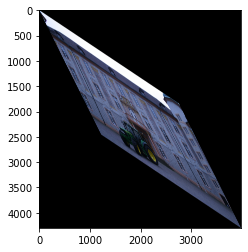

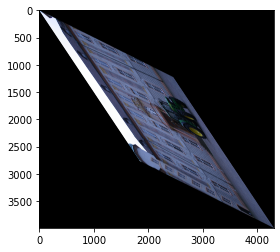

In [ ]:
print(first_rotation)
H= create_affine_transformation(first_rotation,[0,0])

I_aff_step4, corners_transformed, (min_x, min_y) = apply_H(np.array(I_aff_step3), H, return_min_coordinates=True, img_corners=corners_transformed)

plot_img(I_aff_step3)
plot_img(I_aff_step4)

#### Original affinity

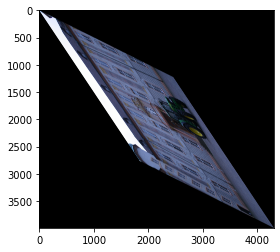

In [ ]:
plot_img(I_aff)

### **1.3 Projective transformations (Homographies)**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a projective transformation.  </span>

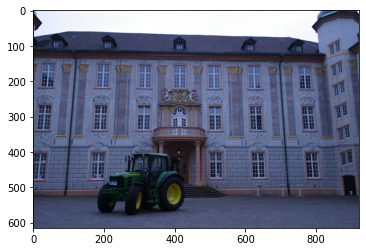

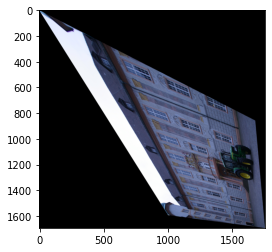

In [ ]:

def create_projective_transformation(affine_matrix, v_vector, translation):
  """
  Create a projective matrix with the given affine matrix, v_vector and translation vector.
  """

  H = np.array([
        [affine_matrix[0][0], affine_matrix[0][1], translation[0]],
        [affine_matrix[1][0], affine_matrix[1][1], translation[1]],
        v_vector
  ])
  return H

translation = [100,20]
affine_matrix=np.array([
                [2,4],
                [3,2]
              ])
nu_vector = np.array([0.001,0.001,0.8])

if ((affine_matrix[0][0]*affine_matrix[1][1]) - (affine_matrix[0][1]*affine_matrix[1][0])) == 0:
  print(affine_matrix)
  print('affine matrix must be non singular, determinant !=0')

H = create_projective_transformation(affine_matrix, nu_vector,translation)

img_path = "./Data/0005_s.png"
I = Image.open(img_path)

I_proj = apply_H(np.array(I), H)

plot_img(I)
plot_img(I_proj)

## **2. Affine Rectification**

This step is needed in order to rectify an image in a stratified way, where we first perform affine rectification (current section) and then metric rectification (Section 3).

In [ ]:
# load images and lines
img_path = "./Data/0000_s.png"
I = Image.open(img_path)

lines_path = "./Data/0000_s_info_lines.txt"
A = np.loadtxt(lines_path)

# points of interest
i = 423 # line index
p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
p2 = [A[i, 2], A[i, 3], 1] # final point in line i
i = 239
p3 = [A[i, 0], A[i, 1], 1]
p4 = [A[i, 2], A[i, 3], 1]
i = 711
p5 = [A[i, 0], A[i, 1], 1]
p6 = [A[i, 2], A[i, 3], 1]
i = 564
p7 = [A[i, 0], A[i, 1], 1]
p8 = [A[i, 2], A[i, 3], 1]

<span style='color:Green'> - Compute the lines l1, l2, l3, l4, that pass through the different pairs of points.  </span>

In [ ]:
l1 = np.cross(p1, p2)
l2 = np.cross(p3, p4)
l3 = np.cross(p5, p6)
l4 = np.cross(p7, p8)

l1,l2,l3,l4

(array([ 1.64126500e+00,  3.62322760e+01, -1.05741194e+04]),
 array([ 1.30681100e+00,  2.99975250e+01, -9.75533519e+03]),
 array([ 3.62930480e+01,  1.23715900e+00, -1.08112162e+04]),
 array([-2.99966130e+01, -3.18747000e-01,  9.91817675e+03]))

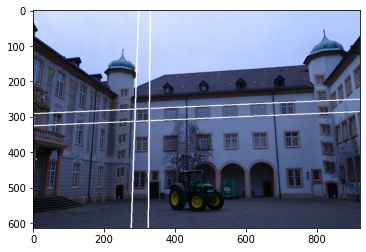

In [ ]:
# show the chosen lines in the image
canv = ImageDraw.Draw(I)
point_color = (0, 0, 255)
line_draw(l1, canv, I.size)
line_draw(l2, canv, I.size)
line_draw(l3, canv, I.size)
line_draw(l4, canv, I.size)

# The displayed lines will alter image I so we have to reopen the original image after the plot
plot_img(I)
I = Image.open(img_path)

<span style='color:Green'> - Compute the homography that affinely rectifies the image </span>

v1 before = [1.23233298e+05 9.42813212e+05 1.27373948e+09]
v1 after = [9.67492178e-05 7.40193130e-04 1.00000000e+00]
Homography matrix that affinely rectifies the image:
[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [9.67492178e-05 7.40193130e-04 1.00000000e+00]]


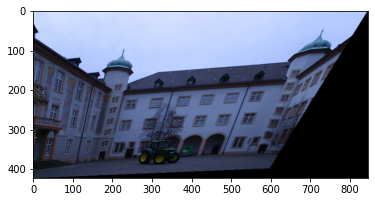

In [ ]:
# 1. Take two sets of two parallel lines in the image
l1, l2
l3, l4

# 2. Each one provides a vanishing point
vp1 = np.cross(l1, l2)
vp2 = np.cross(l3, l4)

# 3. Compute the vanishing line
vl = np.cross(vp1, vp2)
print(f'v1 before = {vl}')
vl = vl / vl[2]
print(f'v1 after = {vl}')

# 4. Compute the affine rectification matrix
Haffine_rec = np.array([[1,0,0], [0,1,0], vl])
print('Homography matrix that affinely rectifies the image:')
print(Haffine_rec)

# 5. Apply the affine rectification to the image
I_affine_rec = apply_H(np.array(I), Haffine_rec)
plot_img(I_affine_rec)

In [ ]:
np.dot(Haffine_rec, vl)

array([9.67492178e-05, 7.40193130e-04, 1.00000056e+00])

<span style='color:Green'> - Compute the transformed lines lr1, lr2, lr3, lr4 and
      show the transformed lines in the transformed image. </span>

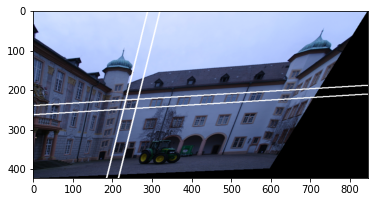

In [ ]:
# Transform points
pr1 = np.dot(Haffine_rec, p1)
pr2 = np.dot(Haffine_rec, p2)
pr3 = np.dot(Haffine_rec, p3)
pr4 = np.dot(Haffine_rec, p4)
pr5 = np.dot(Haffine_rec, p5)
pr6 = np.dot(Haffine_rec, p6)
pr7 = np.dot(Haffine_rec, p7)
pr8 = np.dot(Haffine_rec, p8)

# Get transformed lines
lr1 = np.cross(pr1, pr2)
lr2 = np.cross(pr3, pr4)
lr3 = np.cross(pr5, pr6)
lr4 = np.cross(pr7, pr8)

# Show the transformed lines in the transformed image
I_affine_rec = Image.fromarray(I_affine_rec)
canv = ImageDraw.Draw(I_affine_rec)
point_color = (0, 0, 255)
line_draw(lr1, canv, I_affine_rec.size)
line_draw(lr2, canv, I_affine_rec.size)
line_draw(lr3, canv, I_affine_rec.size)
line_draw(lr4, canv, I_affine_rec.size)

plot_img(I_affine_rec)

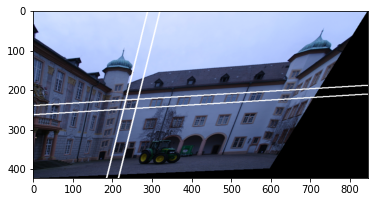

In [ ]:
# Another (equivalent) way

I_affine_rec = apply_H(np.array(I), Haffine_rec)

# dual of H: l' = H^-T l
Haffine_inv_T = np.linalg.inv(Haffine_rec.T)

# Show the transformed lines in the transformed image
I_affine_rec = Image.fromarray(I_affine_rec)
canv = ImageDraw.Draw(I_affine_rec)
point_color = (0, 0, 255)
line_draw(Haffine_inv_T @ l1, canv, I_affine_rec.size)
line_draw(Haffine_inv_T @ l2, canv, I_affine_rec.size)
line_draw(Haffine_inv_T @ l3, canv, I_affine_rec.size)
line_draw(Haffine_inv_T @ l4, canv, I_affine_rec.size)

plot_img(I_affine_rec)

<span style='color:Green'> - To evaluate the results, compute the angle between the different pair 
      of lines before and after the image transformation. </span>

In [ ]:
def angle_between_lines(l, m):
    """Compute the angle between two lines in R2."""
    
    num = np.dot(l, m)
    den = np.linalg.norm(l) * np.linalg.norm(m)
    
    return np.arccos(num / den)


def homo2carte(p):
    """Compute the cartesian coordinates (in R2) from
    the given homogeneous coordinates (in P2)."""
    
    return p[[0,1]] / p[2]


# BEFORE
theta1_before = angle_between_lines(homo2carte(l1), homo2carte(l2))
theta2_before = angle_between_lines(homo2carte(l3), homo2carte(l4))
print('Angles before transformation:', theta1_before, theta2_before)

# AFTER
theta1_after = angle_between_lines(homo2carte(lr1), homo2carte(lr2))
theta2_after = angle_between_lines(homo2carte(lr3), homo2carte(lr4))
print('Angles after transformation:', theta1_after, theta2_after)

Angles before transformation: 0.0017310455454696352 0.023449149581986708
Angles after transformation: 0.0 0.0


As we can see, after the image transformation the angle between the pairs of lines is zero, that is, they are parallel. So the affine rectification has been correctly computed.

Summarize all the previous steps in a single function:

In [ ]:
def apply_affine_rectification(I, points, show_lines=False):
    """Use the given points to apply affine rectification 
    over the given image, I."""

    p1, p2, p3, p4, p5, p6, p7, p8 = points
    
    # Compute lines that pass through the given points
    l1 = np.cross(p1, p2)
    l2 = np.cross(p3, p4)
    l3 = np.cross(p5, p6)
    l4 = np.cross(p7, p8)
    
    # Compute their vanishing points
    vp1 = np.cross(l1, l2)
    vp2 = np.cross(l3, l4)

    # Compute the vanishing line
    vl = np.cross(vp1, vp2)
    vl = vl / vl[2]

    # Compute the affine rectification matrix
    Haffine_rec = np.array([[1,0,0], [0,1,0], vl])
    
    # Affinely rectify the image
    I_affine_rec, corners, (min_x, min_y) = apply_H(np.array(I), Haffine_rec, return_min_coordinates=True)
    
    I_ar = Image.fromarray(I_affine_rec)
    if show_lines:
        # Transform points
        pr1 = np.dot(Haffine_rec, p1)
        pr2 = np.dot(Haffine_rec, p2)
        pr3 = np.dot(Haffine_rec, p3)
        pr4 = np.dot(Haffine_rec, p4)
        pr5 = np.dot(Haffine_rec, p5)
        pr6 = np.dot(Haffine_rec, p6)
        pr7 = np.dot(Haffine_rec, p7)
        pr8 = np.dot(Haffine_rec, p8)

        # Get transformed lines
        lr1 = np.cross(pr1, pr2)
        lr2 = np.cross(pr3, pr4)
        lr3 = np.cross(pr5, pr6)
        lr4 = np.cross(pr7, pr8)

        # Display transformed lines
        canv = ImageDraw.Draw(I_ar)
        point_color = (0, 0, 255)
        line_draw(lr1, canv, I_ar.size, color=(255,255,0))
        line_draw(lr2, canv, I_ar.size, color=(255,255,0))
        line_draw(lr3, canv, I_ar.size, color=(0,255,0))
        line_draw(lr4, canv, I_ar.size, color=(0,255,0))

    plot_img(I_ar)
    
    return I_affine_rec, Haffine_rec, (corners, (min_x, min_y))


def display_lines(I, A, ids):
    """Given an image (I), a document with information about its
    lines (A) and a list with the ids of the lines of interest 
    (ids), display the image with the corresponding lines."""
    
    points = []
    lines = []
    for i in ids:
        # Points of interest
        p1 = [A[i, 0], A[i, 1], 1] # initial point in line
        p2 = [A[i, 2], A[i, 3], 1] # final point in line
        points.append(p1)
        points.append(p2)
        
        # Compute corresponding lines
        l = np.cross(p1, p2)
        lines.append(l)
    
    # Show the chosen lines in the image
    I = I.copy()
    canv = ImageDraw.Draw(I)
    point_color = (0, 0, 255)
    for l, color in zip(lines, [(255,255,0)]*(len(lines)//2) + [(0,255,0)]*(len(lines)//2+1)):
        line_draw(l, canv, I.size, color=color)
    
    plot_img(I)
    
    return tuple(points)

## **3. Metric Rectification**

### **3.1 Metric rectification after the affine rectification (stratified solution)**

<span style='color:Green'> - Write the code that performs the metric rectification (after the affine rectification). </span>

As qualitative evaluation method you can display the images (before and after the metric rectification) with the chosen lines printed on it.


In [ ]:
def apply_metric_rectification(I, lines, corners=None, show_lines=False):
    """Use the given pairs of orthogonal lines to apply
    metric rectification over the given image, I."""

    # pairs of orthogonal lines <l',m'> = 0 after rectifying
    l1, m1, l2, m2 = lines
    
    # solve for s = (s11, s12, s22)
    # as scaling is unimportant, we fix s11 = 1
    M = np.array([
        [l1[0]*m1[0], l1[0]*m1[1] + l1[1]*m1[0], l1[1]*m1[1]],
        [l2[0]*m2[0], l2[0]*m2[1] + l2[1]*m2[0], l2[1]*m2[1]],
        [1,0,0]])
    s11, s12, s22 = np.linalg.solve(M, np.array([0,0,1]))

    # build the S matrix, and use Cholesky decomposition to find K
    S = np.array([[s11,s12],[s12, s22]])
    K = np.linalg.cholesky(S)  # K @ K.T == S

    # build the affine transform matrix
    H_affine = np.eye(3)
    H_affine[:-1,:-1] = K

    # display image and lines
    if corners is not None:
        I_metric_rec, corners, (min_x, min_y) = apply_H(np.array(I), np.linalg.inv(H_affine), return_min_coordinates=True, img_corners=corners)
    else:
        I_metric_rec, corners, (min_x, min_y) = apply_H(np.array(I), np.linalg.inv(H_affine), return_min_coordinates=True)
    I_metric_rec = Image.fromarray(I_metric_rec)
    if show_lines:
        canv = ImageDraw.Draw(I_metric_rec)
        line_draw(H_affine.T @ l1, canv, I_metric_rec.size, color=(0,255,0))
        line_draw(H_affine.T @ l2, canv, I_metric_rec.size, color=(255,255,0))
        line_draw(H_affine.T @ m1, canv, I_metric_rec.size, color=(0,255,0))
        line_draw(H_affine.T @ m2, canv, I_metric_rec.size, color=(255,255,0))
    plot_img(I_metric_rec)
        
    return I_metric_rec, np.linalg.inv(H_affine), (corners, (min_x, min_y))

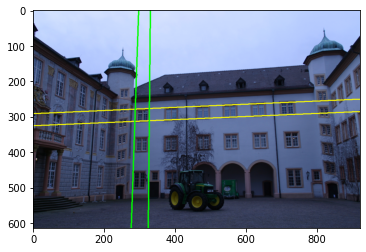

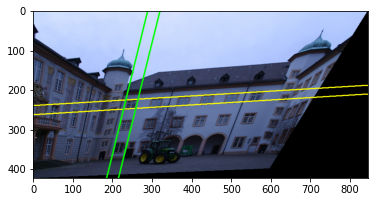

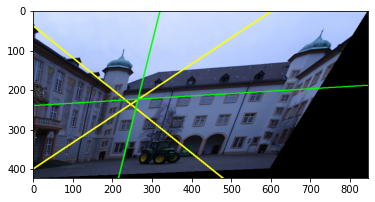

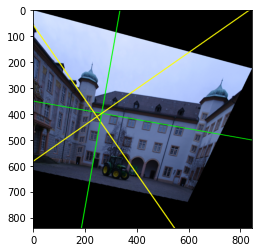

In [ ]:
# lets find two pairs of orthogonal lines
# we will use the assumption that windows are squared
l1_diag = np.cross(np.cross(l1,l3),np.cross(l2,l4))
l2_diag = np.cross(np.cross(l1,l4),np.cross(l2,l3))

# plotting the lines...
I_tmp = I.copy()
canv = ImageDraw.Draw(I_tmp)
line_draw(l1, canv, I_tmp.size, color=(255,255,0))
line_draw(l2, canv, I_tmp.size, color=(255,255,0))
line_draw(l3, canv, I_tmp.size, color=(0,255,0))
line_draw(l4, canv, I_tmp.size, color=(0,255,0))
plot_img(I_tmp)

# rectify!
I_affine_rec, H_affine_rec, _ = apply_affine_rectification(I, [p1, p2, p3, p4, p5, p6, p7, p8], show_lines=True)
lr1_diag, lr2_diag = np.linalg.inv(H_affine_rec.T) @ l1_diag, np.linalg.inv(H_affine_rec.T) @ l2_diag

# plotting the lines...
I_tmp = Image.fromarray(I_affine_rec).copy()
canv = ImageDraw.Draw(I_tmp)
line_draw(lr1_diag, canv, I_tmp.size, color=(255,255,0))
line_draw(lr2_diag, canv, I_tmp.size, color=(255,255,0))
line_draw(lr1, canv, I_tmp.size, color=(0,255,0))
line_draw(lr4, canv, I_tmp.size, color=(0,255,0))
plot_img(I_tmp)

# metric rectification
I_metric_rec, H_metric_rec, _ = apply_metric_rectification(I_affine_rec, [lr1, lr4, lr1_diag, lr2_diag], show_lines=True)

<span style='color:Green'> - Compute the angles between the pair of lines before and after rectification. Comment the result. </span>
      

In [ ]:
# Now orthogonal lines will have a 90 degree angle (pi/2 = 1.5707...) between them.

theta1_before = angle_between_lines(homo2carte(lr1), homo2carte(lr3))
theta2_before = angle_between_lines(homo2carte(lr1_diag), homo2carte(lr2_diag))
print('Angles before transformation:', theta1_before, theta2_before)

H_metric_rec_inv_T = np.linalg.inv(H_metric_rec.T)
theta1_after = angle_between_lines(homo2carte(H_metric_rec_inv_T @ lr1), homo2carte(H_metric_rec_inv_T @ lr3))
theta2_after = angle_between_lines(homo2carte(H_metric_rec_inv_T @ lr1_diag), homo2carte(H_metric_rec_inv_T @ lr2_diag))
print('Angles after transformation:', theta1_after, theta2_after)

Angles before transformation: 1.2678214939074137 1.2568290176865708
Angles after transformation: 1.570796326794898 1.5707963267948966


## **4. Affine and Metric Rectification of the left facade of image 0001**

<span style='color:Green'> - Write the code that rectifies the left facade of image 0001 with
      the stratified method.  </span>
      
Note: For a better visualization of the result crop the initial image so that only the left facade is visible.

<span style='color:Green'> - Show the (properly) transformed lines that are used in every step.  </span>
      

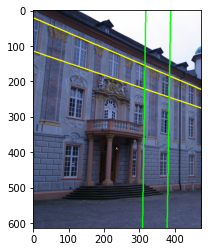

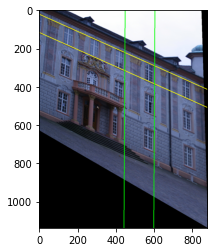

In [ ]:
# AFFINE RECTIFICATION:

# load images and lines
img_path = "./Data/0001_s.png"
I = Image.open(img_path)

lines_path = "./Data/0001_s_info_lines.txt"
A = np.loadtxt(lines_path)

# Crop image
I_crop = np.array(I)[:,:475]
I_crop = Image.fromarray(I_crop)

# Display the chosen lines in the croped image
ids = [613, 158, 540, 644]
p1,p2,p3,p4,p5,p6,p7,p8 = display_lines(I_crop, A, ids)

# we make the assumption that the space between two windows is a square (not exactly true, but okay assumption)
l1, l2, l3, l4 = np.cross(p1, p2), np.cross(p3, p4), np.cross(p5, p6), np.cross(p7, p8)
p1_3, p2_4 = np.cross(l1, l3), np.cross(l2, l4)
p1_4, p2_3 = np.cross(l1, l4), np.cross(l2, l3)

# Display the affinely rectified image with the transformed lines
points = [p1, p2, p3, p4, p5, p6, p7, p8]
I_affine_rec, H_affine_rec, (corners, (min_x, min_y)) = apply_affine_rectification(I_crop, points, show_lines=True)

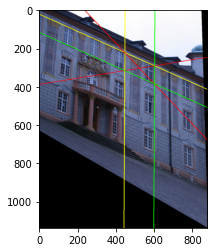

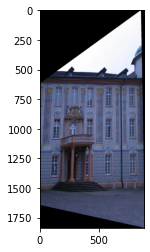

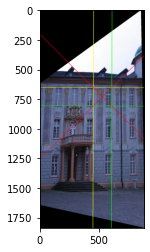

In [ ]:
# Choose the pairs of lines that are orthogonal, and apply affine rect.
# we make the assumption that the space between two windows is a square (not exactly true, but okay assumption)

H_affine_rec_inv_T = np.linalg.inv(H_affine_rec.T)
l1_m = H_affine_rec_inv_T @ np.cross(p1, p2)
m1_m = H_affine_rec_inv_T @ np.cross(p7, p8)
l2_m = H_affine_rec_inv_T @ np.cross(p1_3, p2_4)
m2_m = H_affine_rec_inv_T @ np.cross(p1_4, p2_3)

# Show affinely rectified lines and image
I_tmp = Image.fromarray(I_affine_rec).copy()
canv = ImageDraw.Draw(I_tmp)

line_draw(l1_m, canv, I_tmp.size, color=(255, 255, 0))
line_draw(m1_m, canv, I_tmp.size, color=(255, 255, 0))
line_draw(l2_m, canv, I_tmp.size, color=(255, 0, 0))
line_draw(m2_m, canv, I_tmp.size, color=(255, 0, 0))
line_draw(H_affine_rec_inv_T @ l2, canv, I_tmp.size, color=(0, 255, 0))
line_draw(H_affine_rec_inv_T @ l3, canv, I_tmp.size, color=(0, 255, 0))

plot_img(I_tmp)

# Apply metric rectification
I_metric_rec, H_metric_rec, (corners_m, (min_x, min_y)) = apply_metric_rectification(I_affine_rec, [l1_m, m1_m, l2_m, m2_m], corners=corners)
H_metric_rec_inv_T = np.linalg.inv(H_metric_rec.T)
lines_metr = [H_metric_rec_inv_T @ l1_m, H_metric_rec_inv_T @ m1_m, H_metric_rec_inv_T @ l2_m, H_metric_rec_inv_T @ m2_m, \
                                H_metric_rec_inv_T @ H_affine_rec_inv_T @ l2, H_metric_rec_inv_T @ H_affine_rec_inv_T @ l3]

for i in range(len(lines_metr)):
    lines_metr[i][2] = lines_metr[i][0]*min_x + lines_metr[i][1]*min_y + lines_metr[i][2]

# Show transformed lines and image
I_tmp = I_metric_rec.copy()
canv = ImageDraw.Draw(I_tmp)

line_draw(lines_metr[0], canv, I_tmp.size, color=(255, 255, 0))
line_draw(lines_metr[2], canv, I_tmp.size, color=(255, 0, 0))
line_draw(lines_metr[1], canv, I_tmp.size, color=(255, 255, 0))
line_draw(lines_metr[3], canv, I_tmp.size, color=(255, 0, 0))
line_draw(lines_metr[4], canv, I_tmp.size, color=(0, 255, 0))
line_draw(lines_metr[5], canv, I_tmp.size, color=(0, 255, 0))

plot_img(I_tmp)

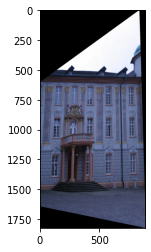

In [ ]:
# We can compose the rectifying transforms to avoid interpolation issues
H_proj2metric = H_affine_rec @ H_metric_rec
I_metric_rec = Image.fromarray(apply_H(np.array(I_crop), H_proj2metric))
plot_img(I_metric_rec)

In [ ]:
# We can check again that the metric rectification works (it should give pi/2 = 1.57079...)

theta1_before = angle_between_lines(homo2carte(l1_m), homo2carte(m1_m))
theta2_before = angle_between_lines(homo2carte(l2_m), homo2carte(m2_m))
print('Angles before transformation:', theta1_before, theta2_before)

H_metric_rec_inv_T = np.linalg.inv(H_metric_rec.T)
theta1_after = angle_between_lines(homo2carte(H_metric_rec_inv_T @ l1_m), homo2carte(H_metric_rec_inv_T @ m1_m))
theta2_after = angle_between_lines(homo2carte(H_metric_rec_inv_T @ l2_m), homo2carte(H_metric_rec_inv_T @ m2_m))
print('Angles after transformation:', theta1_after, theta2_after)

Angles before transformation: 1.9866202094655965 2.1667198102779026
Angles after transformation: 1.5707963267948966 1.5707963267948966


## **5. OPTIONAL: Metric Rectification in a single step**

<span style='color:Green'> - Write the code that performs metric rectification in a single step (algorithm pages 55-57, Hartley-Zisserman book). </span>

Note: Use 5 pairs of orthogonal lines. You may consider that windows are square.

We start with the metric rectification in image '0001_s' with no normalization.

A is: [[ 9.10907475e+01 -1.53293666e+02 -2.49291869e+01  2.23167889e+04
   2.00846088e+04 -6.27670872e+06]
 [ 4.30080603e+02 -4.99970875e+02 -1.72002794e+01 -7.20772579e+04
   1.94918980e+05 -8.55762947e+06]
 [-6.04155526e+02  3.38654280e+03  4.42564188e+02 -1.20098900e+06
  -6.26816366e+05  4.00288393e+08]
 [-4.52193185e+01 -2.33535689e+03 -2.99771188e+01  1.10204886e+06
   1.03281288e+06 -9.59482148e+08]
 [ 4.63906348e+02 -1.28125305e+03 -3.82706232e+01  2.91106823e+05
   4.11800419e+05 -2.30578642e+08]]
Rank of A: 5
D of SVD of S: [8.40924530e-01 1.88634038e-01 1.12290175e-07]
Angles between pairs after and before
Before: 78.35590268237189  After: 71.6666173374416
Before: 67.85726110129715  After: 78.62086245076084
Before: 88.64895678683926  After: 71.80341341774006
Before: 89.07752821302894  After: 78.7029950448895
Before: 80.61888092889845  After: 73.30707444281612


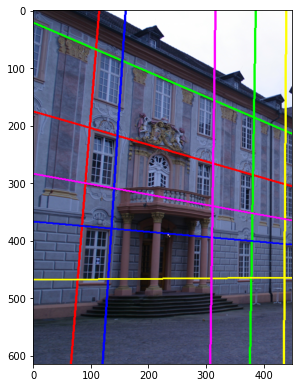

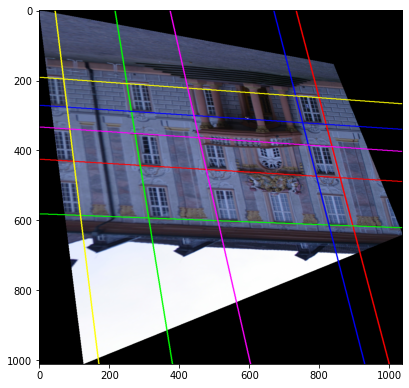

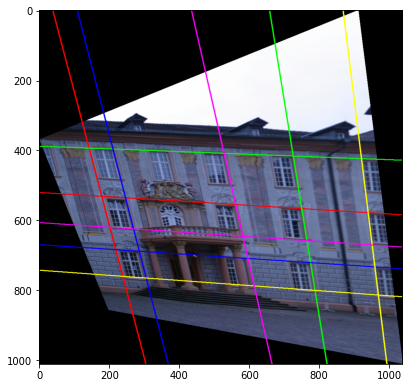

In [ ]:
from scipy.linalg import solve, null_space
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

# Load and preprocess image
img_path_0001s = "./Data/0001_s.png"
I = Image.open(img_path_0001s)
I = Image.fromarray(np.array(I)[:, :450]) # Crop image

def draw_lines(I, lines, point_color=(255, 255, 255)):
  """
  Draw a list of lines in the given color.
  """
  canv = ImageDraw.Draw(I)
  for line in lines:
    line_draw(line, canv, I.size, color=point_color)

def read_line_from_point(i, A):
  """
  Compute line from a given index 'i' in the array A.
  """
  p1 = [A[i, 0], A[i, 1], 1]
  p2 = [A[i, 2], A[i, 3], 1]
  l = np.cross(p1,p2)
  return l

def get_lines_0001s_single_step(n_set=0):
  """
  Obtain set of orthogonal lines for image 0001_s for metric rectification in one single step.
  """
  lines_path = "./Data/0001_s_info_lines.txt"
  A = np.loadtxt(lines_path)
  if n_set == 0:
    points = [314, 300, 613, 540, 187, 336, 283, 297, 644, 169]
  elif n_set == 1:
    points = [314, 300, 613, 540, 187, 336, 644, 169]
  else:
    raise Exception("Non-existing set of lines")
  
  lines = [read_line_from_point(i, A) for i in points]
  
  if n_set == 1:
    # Add also other orthogonal lines
    i = 613 # line index
    p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
    p2 = [A[i, 2], A[i, 3], 1] # final point in line i
    i = 158
    p3 = [A[i, 0], A[i, 1], 1]
    p4 = [A[i, 2], A[i, 3], 1]
    i = 644
    p5 = [A[i, 0], A[i, 1], 1]
    p6 = [A[i, 2], A[i, 3], 1]
    i = 540
    p7 = [A[i, 0], A[i, 1], 1]
    p8 = [A[i, 2], A[i, 3], 1]

    # Parallel lines
    l1, l2, l3, l4 = np.cross(p1, p2), np.cross(p3, p4), np.cross(p5, p6), np.cross(p7, p8)

    # Orthogonal lines from intersection
    p1_3, p2_4 = np.cross(l1, l3), np.cross(l2, l4)
    p1_4, p2_3 = np.cross(l1, l4), np.cross(l2, l3)
    l5, l6 = np.cross(p1_3, p2_4), np.cross(p1_4, p2_3)
    lines.append(l5)
    lines.append(l6)

  return lines

def transform_line(line, H):
  """
  Apply homography 'H' to 'line'.
  """
  resulting_line = np.matmul(np.linalg.inv(H).transpose(1, 0), line)
  resulting_line = resulting_line/np.max(resulting_line)
  return resulting_line

def compute_angle(line1, line2):
  """
  Compute angle between two lines assuming that they have been metrically rectified
  """
  conic_dual = np.array([
                   [1, 0, 0],
                   [0, 1, 0],
                   [0, 0, 0] 
              ])
  num = np.matmul(line1, np.matmul(conic_dual, line2))
  denom = (np.matmul(line1, np.matmul(conic_dual, line1)) * np.matmul(line2, np.matmul(conic_dual, line2)))**0.5
  angle_rad = math.acos(num/denom)
  if angle_rad < 0:
    angle_rad = angle_rad*(-1)
  angle = angle_rad*(180/np.pi)
  if angle > 90:
    angle = 180 - angle
  return angle

def plot_img_med(img, do_not_use=[0]):
    plt.figure(do_not_use[0])
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(14.5, 6.5)
    do_not_use[0] += 1
    plt.imshow(img)

def metric_rectification_image_single_step(img, orthogonal_lines, T_denorm=None):
  """
  Given an image and a list of lines which are orthogonal to each other in the sense that 'orthogonal_lines[i]' is orthogonal to 'orthogonal_lines[i+1]', it performs
  a metric rectification in a single step.

  - T_denorm: It's a denormalizing transformation in case the orthogonal lines have been normalized.

  Returns: The image containing the metric reconstruction, the metrically rectifying homography, the minimum x and y that is obtained after applying the rectifying
      homography to the image
  """
  # Metric rectification in a single step
  orthogonal_lines = [[orthogonal_lines[i*2], orthogonal_lines[i*2+1]] for i in range(len(orthogonal_lines)//2)]
  
  # Compute constraints of orthogonal lines and create matrix A encoding those
  A = np.array(
      [[l1[0]*l2[0],(l1[0]*l2[1] + l1[1]*l2[0])/2, l1[1]*l2[1],(l1[0]*l2[2] + l1[2]*l2[0])/2,(l1[1]*l2[2] + l1[2]*l2[1])/2, l1[2]*l2[2]] for l1, l2 in orthogonal_lines]
  )
  print("A is:", A)
  print("Rank of A:", np.linalg.matrix_rank(A))
  # The nullspace of A contains the coefficients of the conic dual to the circular points 
  s = null_space(A).reshape(-1)

  # Create matrix S representing the conic dual to the circular points 
  S = np.array([
      [s[0], s[1]/2, s[3]/2], 
      [s[1]/2, s[2], s[4]/2],
      [s[3]/2, s[4]/2, s[5]]
  ])
 
  # D should be equal to
  #  [1, 0, 0]
  #  [0, 1, 0]
  #  [0, 0, 0]
  # in a Euclidean coordinate frame
  U, D, Vt = np.linalg.svd(S)
  print("D of SVD of S:", D)

  # The homography that metrically rectifies the image is the inverse of U, as U is orthogonal is the same as transposing it
  H_metric_rect = U.transpose(1, 0) # or Vt

  if T_denorm is not None:
    H_metric_rect = np.dot(T_denorm, H_metric_rect)
    rect_img, _, (minX, minY) = apply_H(np.array(img), np.dot(H_metric_rect, np.linalg.inv(T_denorm)), return_min_coordinates=True)
  else:
    rect_img, _, (minX, minY) = apply_H(np.array(img), H_metric_rect, return_min_coordinates=True)

  I_metr_rect = Image.fromarray(rect_img)
  return I_metr_rect, H_metric_rect, (minX, minY)

# Load orthogonal lines and show the original image with the lines
orthogonal_lines = get_lines_0001s_single_step(n_set=0)
I_cp = I.copy()
colors_to_draw = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255)]
for i in range(len(orthogonal_lines)//2):
  draw_lines(I_cp, [orthogonal_lines[i*2], orthogonal_lines[i*2+1]], point_color=colors_to_draw[i])
plot_img_med(I_cp)

# Metrically rectify the image and show the result
I_rect, H_rect, (minX, minY) = metric_rectification_image_single_step(np.array(I), orthogonal_lines)
orthogonal_lines_after = [transform_line(l, H_rect) for l in orthogonal_lines]
orthogonal_lines_after = [np.array([l[0], l[1], l[2]+l[1]*minY+l[0]*minX]) for l in orthogonal_lines_after]
for i in range(len(orthogonal_lines)//2):
  draw_lines(I_rect, [orthogonal_lines_after[i*2], orthogonal_lines_after[i*2+1]], point_color=colors_to_draw[i])
plot_img_med(I_rect)

# 180º flip to better see the image
T = create_similarity_transformation(1, np.pi, [0, 0])
I_rect = apply_H(np.array(I_rect), T)
plot_img_med(I_rect)

print("Angles between pairs after and before")
for i in range(5):
  print("Before:", compute_angle(orthogonal_lines[i*2], orthogonal_lines[i*2+1]), " After:", compute_angle(orthogonal_lines_after[i*2], orthogonal_lines_after[i*2+1]))

We can implement a similar strategy to the normalization of the normalized DLT algorithm to improve the results of the single step metric rectification. Results in image '0001_s' with normalization:

A is: [[ 0.00576797 -0.00970673 -0.00157854 -0.00107622 -0.01204339 -0.01051434]
 [ 0.02723319 -0.03165872 -0.00108914 -0.06055547  0.03564891  0.10278779]
 [-0.03825581  0.21443971  0.02802366 -0.16407679  0.1573942  -0.23126304]
 [-0.00286334 -0.14787743 -0.00189818  0.19574686  0.23580143 -0.61381154]
 [ 0.02937507 -0.08113039 -0.00242334  0.00802953  0.04804178 -0.01957433]]
Rank of A: 5
D of SVD of S: [0.8165906  0.47908501 0.00540099]
Angles between pairs before and after metric reconstruction:
Angle before: 78.35590268237185  after: 80.82261776407154
Angle before: 67.85726110129717  after: 83.38154808031338
Angle before: 88.64895678683925  after: 80.98515206344321
Angle before: 89.07752821302888  after: 81.94289083255653
Angle before: 80.61888092889843  after: 80.15360388458704


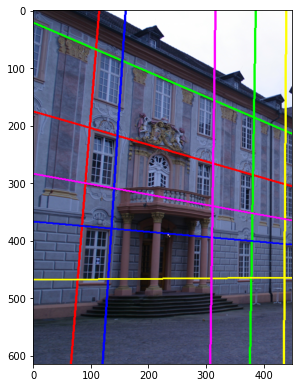

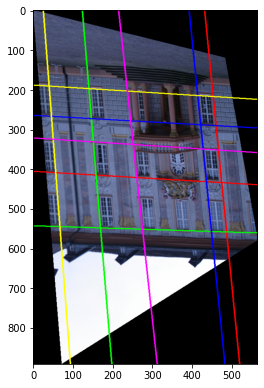

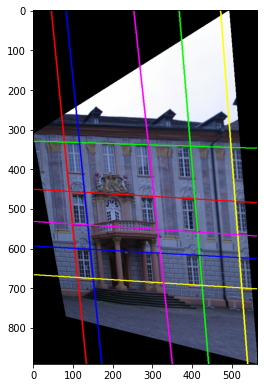

In [ ]:
img_path_0001s = "./Data/0001_s.png"
I = Image.open(img_path_0001s)
I = Image.fromarray(np.array(I)[:, :450]) # Crop image

def read_points(i, A):
  p1 = [A[i, 0], A[i, 1], 1]
  p2 = [A[i, 2], A[i, 3], 1]
  return (p1, p2)

def get_lines_0001s_single_step_norm(n_set=0):
  """
  Get orthogonal lines from image 0001s normalizing first point coordinates and returning the denormalizing transformation for further processing.
  """
  lines_path = "./Data/0001_s_info_lines.txt"
  A = np.loadtxt(lines_path)
  if n_set == 0:
    points = [314, 300, 613, 540, 187, 336, 283, 297, 644, 169]
  elif n_set == 1:
    points = [314, 300, 613, 540, 187, 336, 644, 169]
  else:
    raise Exception("Non-existing set of lines")
  
  points = [read_points(i, A) for i in points]
  points_flatten = []
  for p1,p2 in points:
      points_flatten.append(p1)
      points_flatten.append(p2)
  
  points_flatten = np.array(points_flatten)
  
  T_norm = compute_normalizing_H(points_flatten.T)
  points_normalized = np.dot(T_norm, points_flatten.transpose(1, 0)).transpose(1, 0)
  points = points_normalized / points_normalized[:, 2, np.newaxis]
  lines = [np.cross(points[i*2, :], points[i*2+1, :]) for i in range(points.shape[0]//2)]
  
  if n_set == 1:
    # Add also other orthogonal lines
    i = 613 # line index
    p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
    p2 = [A[i, 2], A[i, 3], 1] # final point in line i
    i = 158
    p3 = [A[i, 0], A[i, 1], 1]
    p4 = [A[i, 2], A[i, 3], 1]
    i = 644
    p5 = [A[i, 0], A[i, 1], 1]
    p6 = [A[i, 2], A[i, 3], 1]
    i = 540
    p7 = [A[i, 0], A[i, 1], 1]
    p8 = [A[i, 2], A[i, 3], 1]

    p1, p2, p3, p4, p5, p6, p7, p8 = T_norm @ np.array(p1), T_norm @ np.array(p2), T_norm @ np.array(p3), T_norm @ np.array(p4), \
                                      T_norm @ np.array(p5), T_norm @ np.array(p6), T_norm @ np.array(p7), T_norm @ np.array(p8)

    # Parallel lines
    l1, l2, l3, l4 = np.cross(p1, p2), np.cross(p3, p4), np.cross(p5, p6), np.cross(p7, p8)

    # Orthogonal lines from intersection
    p1_3, p2_4 = np.cross(l1, l3), np.cross(l2, l4)
    p1_4, p2_3 = np.cross(l1, l4), np.cross(l2, l3)
    l5, l6 = np.cross(p1_3, p2_4), np.cross(p1_4, p2_3)

    lines.append(l5)
    lines.append(l6)

  T_denorm = np.linalg.inv(T_norm)
  return lines, T_denorm

def compute_normalizing_H(points):
  """
  Compute a normalizing homography given a set of points with shape (3, n)
  """
  translation = points[:2].mean(axis=1)
  diff = points[:2]-translation[:, np.newaxis]
  mean_sqr_dist = np.mean((diff[0,:]**2 + diff[1,:]**2)**0.5)
  scale = (2**0.5) / mean_sqr_dist
  translation = translation.reshape(-1)

  H = np.array([
    [scale, 0    , -scale*translation[0] ],
    [0    , scale, -scale*translation[1] ],
    [0    , 0    , 1                     ]
  ])

  return H

# Load orthogonal lines and show the original image with the lines
orthogonal_lines, T_denorm = get_lines_0001s_single_step_norm(n_set=0)
I_cp = I.copy()
colors_to_draw = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255)]
orthogonal_lines_show = [np.dot(np.linalg.inv(T_denorm).transpose(1,0),orth_line) for orth_line in orthogonal_lines]
for i in range(len(orthogonal_lines_show)//2):
  draw_lines(I_cp, [orthogonal_lines_show[i*2], orthogonal_lines_show[i*2+1]], point_color=colors_to_draw[i])
plot_img_med(I_cp)

# Metrically rectify the image and show the result
I_rect, H_rect, (minX, minY) = metric_rectification_image_single_step(np.array(I), orthogonal_lines, T_denorm=T_denorm)
orthogonal_lines_after = [transform_line(l, H_rect) for l in orthogonal_lines]
orthogonal_lines_after = [np.array([l[0], l[1], l[2]+l[1]*minY+l[0]*minX]) for l in orthogonal_lines_after]
for i in range(len(orthogonal_lines_after)//2):
  draw_lines(I_rect, [orthogonal_lines_after[i*2], orthogonal_lines_after[i*2+1]], point_color=colors_to_draw[i])
plot_img_med(I_rect)

# 180º flip to better see the image
T = create_similarity_transformation(1, np.pi, [0, 0])
I_rect = apply_H(np.array(I_rect), T)
plot_img_med(I_rect)

print("Angles between pairs before and after metric reconstruction:")
for i in range(5):
  print("Angle before:", compute_angle(orthogonal_lines[i*2], orthogonal_lines[i*2+1]), " after:", compute_angle(orthogonal_lines_after[i*2], orthogonal_lines_after[i*2+1]))

We can also try with another set of lines:

A is: [[ 6.99290856e-03 -1.17681392e-02 -1.91377861e-03  1.08287286e-03
  -1.56684598e-02 -8.65979692e-03]
 [ 3.30166829e-02 -3.83820608e-02 -1.32044126e-03 -7.26176241e-02
   4.78667876e-02  1.30634891e-01]
 [-4.63801699e-02  2.59980127e-01  3.39750302e-02 -2.74677815e-01
   2.02862317e-01 -4.28360874e-01]
 [ 3.56134378e-02 -9.83599945e-02 -2.93798191e-03  3.17749599e-02
   6.47501719e-02 -5.63520201e-02]
 [ 1.41040234e-05  8.33142658e-06 -2.10480343e-05 -8.45793591e-06
  -2.17389419e-05 -5.72208224e-06]]
Rank of A: 5
D of SVD of S: [0.85502785 0.43325525 0.01041406]
Angles between pairs before and after metric reconstruction:
Angle before: 78.35590268237183  after: 78.6503597331995
Angle before: 67.85726110129711  after: 81.3828465540798
Angle before: 88.64895678683925  after: 79.27776769059145
Angle before: 80.61888092889843  after: 78.59509828604149
Angle before: 79.71742887094655  after: 74.29052607998342


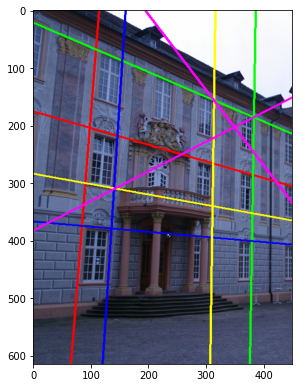

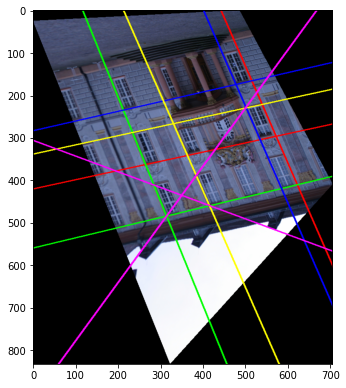

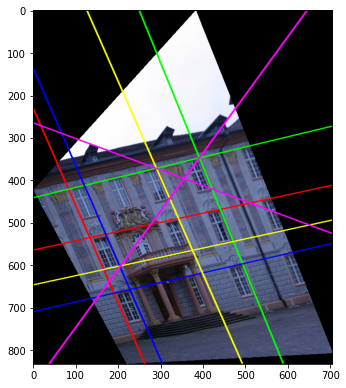

In [ ]:
img_path_0001s = "./Data/0001_s.png"
I = Image.open(img_path_0001s)
I = Image.fromarray(np.array(I)[:, :450]) # Crop image

def read_points(i, A):
  p1 = [A[i, 0], A[i, 1], 1]
  p2 = [A[i, 2], A[i, 3], 1]
  return (p1, p2)

def get_lines_0001s_single_step(n_set=0):
  """
  Get orthogonal lines from image 0001s normalizing first point coordinates and returning the denormalizing transformation for further processing.
  """
  lines_path = "./Data/0001_s_info_lines.txt"
  A = np.loadtxt(lines_path)
  if n_set == 0:
    points = [314, 300, 613, 540, 187, 336, 283, 297, 644, 169]
  elif n_set == 1:
    points = [314, 300, 613, 540, 187, 336, 644, 169]
  else:
    raise Exception("Non-existing set of lines")
  
  points = [read_points(i, A) for i in points]
  points_flatten = []
  for p1,p2 in points:
      points_flatten.append(p1)
      points_flatten.append(p2)
  
  points_flatten = np.array(points_flatten)
  
  T_norm = compute_normalizing_H(points_flatten.T)
  points_normalized = np.dot(T_norm, points_flatten.transpose(1, 0)).transpose(1, 0)
  points = points_normalized / points_normalized[:, 2, np.newaxis]
  lines = [np.cross(points[i*2, :], points[i*2+1, :]) for i in range(points.shape[0]//2)]
  
  if n_set == 1:
    # Add also other orthogonal lines
    i = 613 # line index
    p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
    p2 = [A[i, 2], A[i, 3], 1] # final point in line i
    i = 158
    p3 = [A[i, 0], A[i, 1], 1]
    p4 = [A[i, 2], A[i, 3], 1]
    i = 644
    p5 = [A[i, 0], A[i, 1], 1]
    p6 = [A[i, 2], A[i, 3], 1]
    i = 540
    p7 = [A[i, 0], A[i, 1], 1]
    p8 = [A[i, 2], A[i, 3], 1]

    p1, p2, p3, p4, p5, p6, p7, p8 = T_norm @ np.array(p1), T_norm @ np.array(p2), T_norm @ np.array(p3), T_norm @ np.array(p4), \
                                      T_norm @ np.array(p5), T_norm @ np.array(p6), T_norm @ np.array(p7), T_norm @ np.array(p8)

    # Parallel lines
    l1, l2, l3, l4 = np.cross(p1, p2), np.cross(p3, p4), np.cross(p5, p6), np.cross(p7, p8)

    # Orthogonal lines from intersection
    p1_3, p2_4 = np.cross(l1, l3), np.cross(l2, l4)
    p1_4, p2_3 = np.cross(l1, l4), np.cross(l2, l3)
    l5, l6 = np.cross(p1_3, p2_4), np.cross(p1_4, p2_3)

    lines.append(l5)
    lines.append(l6)

  T_denorm = np.linalg.inv(T_norm)
  return lines, T_denorm

# Load orthogonal lines and show the original image with the lines
orthogonal_lines, T_denorm = get_lines_0001s_single_step(n_set=1)
I_cp = I.copy()
colors_to_draw = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255)]

orthogonal_lines_show = [np.dot(np.linalg.inv(T_denorm).transpose(1,0),orth_line) for orth_line in orthogonal_lines]

for i in range(len(orthogonal_lines_show)//2):
  draw_lines(I_cp, [orthogonal_lines_show[i*2], orthogonal_lines_show[i*2+1]], point_color=colors_to_draw[i])
plot_img_med(I_cp)

# Metrically rectify the image and show the result
I_rect, H_rect, (minX, minY) = metric_rectification_image_single_step(np.array(I), orthogonal_lines, T_denorm=T_denorm)
orthogonal_lines_after = [transform_line(l, H_rect) for l in orthogonal_lines]
orthogonal_lines_after = [np.array([l[0], l[1], l[2]+l[1]*minY+l[0]*minX]) for l in orthogonal_lines_after]
for i in range(len(orthogonal_lines_after)//2):
  draw_lines(I_rect, [orthogonal_lines_after[i*2], orthogonal_lines_after[i*2+1]], point_color=colors_to_draw[i])
plot_img_med(I_rect)

# 180º flip to better see the image
T = create_similarity_transformation(1, np.pi, [0, 0])
I_rect = apply_H(np.array(I_rect), T)
plot_img_med(I_rect)

print("Angles between pairs before and after metric reconstruction:")
for i in range(5):
  print("Angle before:", compute_angle(orthogonal_lines[i*2], orthogonal_lines[i*2+1]), " after:", compute_angle(orthogonal_lines_after[i*2], orthogonal_lines_after[i*2+1]))

We can also obtain bad results with another set of orthogonal lines:

A is: [[-2.76218250e-03 -1.42653232e-01 -1.83112606e-03  1.62826298e-01
   2.34959288e-01 -5.26623253e-01]
 [ 2.83373133e-02 -7.82642213e-02 -2.33772752e-03 -7.28996430e-03
   5.16373992e-02 -2.66690313e-03]
 [ 4.49849128e-06  2.65731620e-06 -6.71328997e-06 -1.84667460e-06
  -8.76358952e-06 -6.34935445e-06]
 [-1.37629736e-05 -3.58963277e-06  1.42597052e-05  1.27378370e-05
   4.49262052e-06 -1.16989188e-05]
 [-8.23597885e-04 -5.54966750e-05  1.30485264e-03  8.15711427e-04
  -1.12537400e-03  2.56755696e-04]]
Rank of A: 5
D of SVD of S: [0.5888362  0.50354408 0.33102639]
Angles between pairs before and after metric reconstruction:
Angle before: 89.07752821302897  after: 30.24612810575607
Angle before: 80.61888092889848  after: 0.7473294834335036
Angle before: 79.71742887094642  after: 29.591189829735157
Angle before: 89.01609823349467  after: 36.80094080234736
Angle before: 76.95014063467335  after: 5.74489059022469


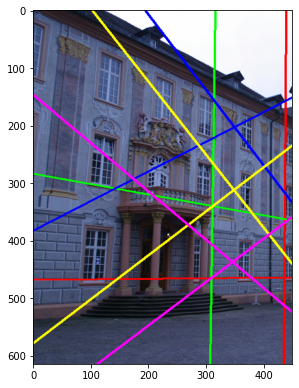

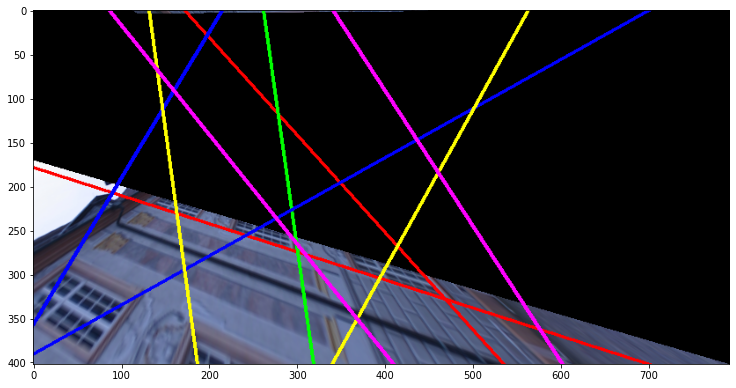

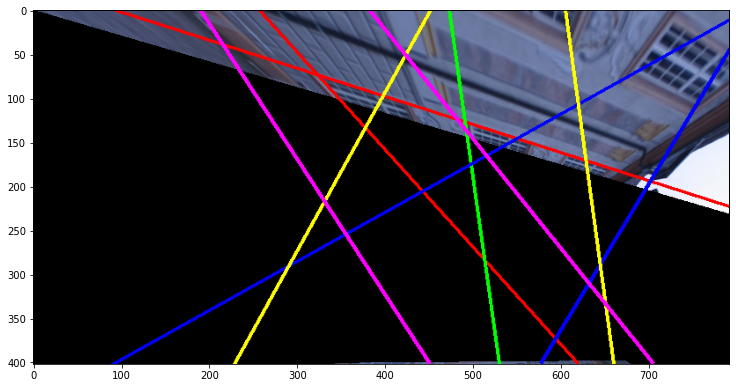

In [ ]:
img_path_0001s = "./Data/0001_s.png"
I = Image.open(img_path_0001s)
I = Image.fromarray(np.array(I)[:, :450]) # Crop image

def read_points(i, A):
  p1 = [A[i, 0], A[i, 1], 1]
  p2 = [A[i, 2], A[i, 3], 1]
  return (p1, p2)

def get_diags(A, idxs, T_norm):
  # Add also other orthogonal lines
  i = idxs[0] # line index
  p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
  p2 = [A[i, 2], A[i, 3], 1] # final point in line i
  i = idxs[1]
  p3 = [A[i, 0], A[i, 1], 1]
  p4 = [A[i, 2], A[i, 3], 1]
  i = idxs[2]
  p5 = [A[i, 0], A[i, 1], 1]
  p6 = [A[i, 2], A[i, 3], 1]
  i = idxs[3]
  p7 = [A[i, 0], A[i, 1], 1]
  p8 = [A[i, 2], A[i, 3], 1]

  p1, p2, p3, p4, p5, p6, p7, p8 = T_norm @ np.array(p1), T_norm @ np.array(p2), T_norm @ np.array(p3), T_norm @ np.array(p4), \
                                    T_norm @ np.array(p5), T_norm @ np.array(p6), T_norm @ np.array(p7), T_norm @ np.array(p8)

  # Parallel lines
  l1, l2, l3, l4 = np.cross(p1, p2), np.cross(p3, p4), np.cross(p5, p6), np.cross(p7, p8)

  # Orthogonal lines from intersection
  p1_3, p2_4 = np.cross(l1, l3), np.cross(l2, l4)
  p1_4, p2_3 = np.cross(l1, l4), np.cross(l2, l3)
  l5, l6 = np.cross(p1_3, p2_4), np.cross(p1_4, p2_3)
  return l5, l6

def get_lines_0001s_single_step(n_set=0):
  """
  Get orthogonal lines from image 0001s normalizing first point coordinates and returning the denormalizing transformation for further processing.
  """
  lines_path = "./Data/0001_s_info_lines.txt"
  A = np.loadtxt(lines_path)
  if n_set == 0:
    points = [314, 300, 613, 540, 187, 336, 644, 169, 644, 169]
  elif n_set == 1: # [300, 540, 644, 169]
    points = [283, 297, 644, 169] #[540, 644, 283, 208] #[314, 300, 613, 540, 283, 297, 644, 169, 187, 336, 158, 644] # [613, 158, 540, 644]
  else:
    raise Exception("Non-existing set of lines")

  points = [read_points(i, A) for i in points]
  points_flatten = []
  for p1,p2 in points:
      points_flatten.append(p1)
      points_flatten.append(p2)
  
  points_flatten = np.array(points_flatten)
  
  T_norm = compute_normalizing_H(points_flatten.T)
  points_normalized = np.dot(T_norm, points_flatten.transpose(1, 0)).transpose(1, 0)
  points = points_normalized / points_normalized[:, 2, np.newaxis]
  lines = [np.cross(points[i*2, :], points[i*2+1, :]) for i in range(points.shape[0]//2)]
  
  if n_set == 1:
    diag_l1, diag_l2 = get_diags(A, [613, 158, 644, 540], T_norm)
    lines.append(diag_l1)
    lines.append(diag_l2)

    diag_l1, diag_l2 = get_diags(A, [540, 644, 300, 169], T_norm)
    lines.append(diag_l1)
    lines.append(diag_l2)

    diag_l1, diag_l2 = get_diags(A, [540, 644, 283, 208], T_norm)
    lines.append(diag_l1)
    lines.append(diag_l2)

  T_denorm = np.linalg.inv(T_norm)
  return lines, T_denorm

# Load orthogonal lines and show the original image with the lines
orthogonal_lines, T_denorm = get_lines_0001s_single_step(n_set=1)
I_cp = I.copy()
colors_to_draw = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255), (0,255,255), (255,255,255), (255,0,0), (0,255,0), (0,0,255)]

orthogonal_lines_show = [np.dot(np.linalg.inv(T_denorm).transpose(1,0),orth_line) for orth_line in orthogonal_lines]

for i in range(len(orthogonal_lines_show)//2):
  draw_lines(I_cp, [orthogonal_lines_show[i*2], orthogonal_lines_show[i*2+1]], point_color=colors_to_draw[i])
plot_img_med(I_cp)

# Metrically rectify the image and show the result
I_rect, H_rect, (minX, minY) = metric_rectification_image_single_step(np.array(I), orthogonal_lines, T_denorm=T_denorm)
orthogonal_lines_after = [transform_line(l, H_rect) for l in orthogonal_lines]
orthogonal_lines_after = [np.array([l[0], l[1], l[2]+l[1]*minY+l[0]*minX]) for l in orthogonal_lines_after]
for i in range(len(orthogonal_lines_after)//2):
  draw_lines(I_rect, [orthogonal_lines_after[i*2], orthogonal_lines_after[i*2+1]], point_color=colors_to_draw[i])
plot_img_med(I_rect)

# Flip the image by 180º for better visualization
T = create_similarity_transformation(1, np.pi, [0, 0])
I_rect = apply_H(np.array(I_rect), T)
plot_img_med(I_rect)

print("Angles between pairs before and after metric reconstruction:")
for i in range(5):
  print("Angle before:", compute_angle(orthogonal_lines[i*2], orthogonal_lines[i*2+1]), " after:", compute_angle(orthogonal_lines_after[i*2], orthogonal_lines_after[i*2+1]))



Metric rectification in 0000_s

Rank of A: 5
Nullspace dim: 1
D of SVD of S: [0.81240563 0.58193207 0.01341989]
Angles between pairs before and after metric reconstruction:
Angle before: 85.4540194633982  after: 88.69839994414056
Angle before: 86.89673837151247  after: 89.40377736272113
Angle before: 88.31600814385756  after: 89.31186675738273
Angle before: 88.07955208665533  after: 88.68825738264066
Angle before: 80.9563376203384  after: 81.30383068868534


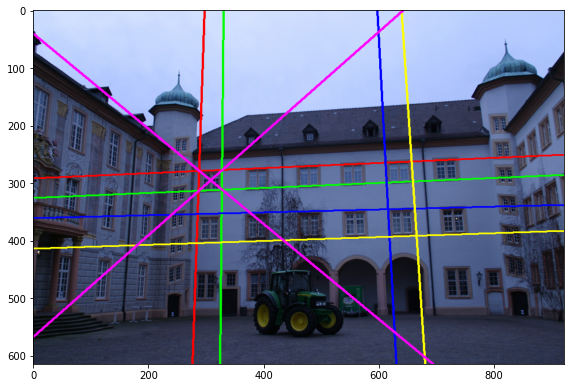

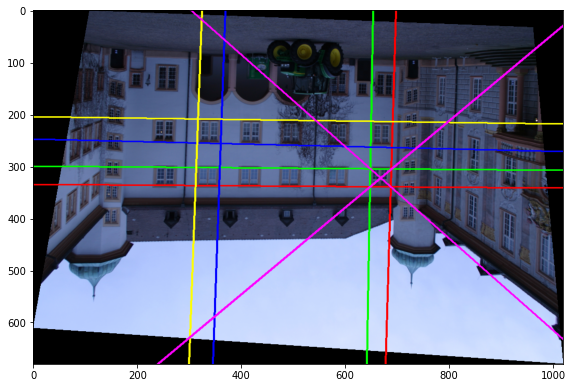

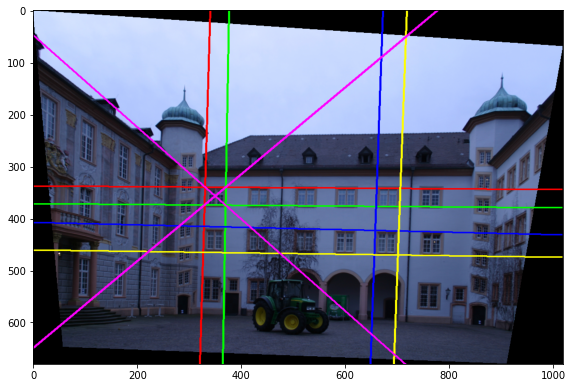

In [ ]:
img_path_0000s = "./Data/0000_s.png"
I = Image.open(img_path_0000s)

def get_lines_0000s_single_step(n_set=0):
  """
  Get orthogonal lines from image 0000s normalizing first point coordinates and returning the denormalizing transformation for further processing.
  """
  lines_path = "./Data/0000_s_info_lines.txt"
  A = np.loadtxt(lines_path)

  points = [423, 711, 564, 239, 533, 226, 575, 366]
  
  points = [read_points(i, A) for i in points]
  points_flatten = []
  for p1,p2 in points:
      points_flatten.append(p1)
      points_flatten.append(p2)
  
  points_flatten = np.array(points_flatten)
  
  T_norm = compute_normalizing_H(points_flatten.T)
  points_normalized = np.dot(T_norm, points_flatten.transpose(1, 0)).transpose(1, 0)
  points = points_normalized / points_normalized[:, 2, np.newaxis]
  lines = [np.cross(points[i*2, :], points[i*2+1, :]) for i in range(points.shape[0]//2)]
  
  p1, p2, p3, p4, p5, p6, p7, p8 = points[2*0], points[2*0+1], points[2*3], points[2*3+1], points[2*1], points[2*1+1], points[2*2], points[2*2+1]

  # Parallel lines
  l1, l2, l3, l4 = np.cross(p1, p2), np.cross(p3, p4), np.cross(p5, p6), np.cross(p7, p8)

  # Orthogonal lines from intersection
  p1_3, p2_4 = np.cross(l1, l3), np.cross(l2, l4)
  p1_4, p2_3 = np.cross(l1, l4), np.cross(l2, l3)
  l5, l6 = np.cross(p1_3, p2_4), np.cross(p1_4, p2_3)

  lines.append(l5)
  lines.append(l6)

  T_denorm = np.linalg.inv(T_norm)
  return lines, T_denorm

def metric_rectification_image_single_step2(img, orthogonal_lines, T_denorm=None):
  # Metric rectification in a single step
  orthogonal_lines = [[orthogonal_lines[i*2], orthogonal_lines[i*2+1]] for i in range(len(orthogonal_lines)//2)]
  A = np.array(
      [[l1[0]*l2[0],(l1[0]*l2[1] + l1[1]*l2[0])/2, l1[1]*l2[1],(l1[0]*l2[2] + l1[2]*l2[0])/2,(l1[1]*l2[2] + l1[2]*l2[1])/2, l1[2]*l2[2]] for l1, l2 in orthogonal_lines]
  )
  print("Rank of A:", np.linalg.matrix_rank(A))
  s = null_space(A).reshape(-1)
  print("Nullspace dim:", len(s)//6)

  # Dual of the absolute conic to the circular points
  S = np.array([
      [s[0], s[1]/2, s[3]/2], 
      [s[1]/2, s[2], s[4]/2],
      [s[3]/2, s[4]/2, s[5]]
  ])
 
  U, D, Vt = np.linalg.svd(S)
  print("D of SVD of S:", D)

  H_metric_rect = U.transpose(1, 0)
  if T_denorm is not None:
    H_metric_rect = np.dot(T_denorm, H_metric_rect)
    rect_img, _, (minX, minY) = apply_H(np.array(img), np.dot(H_metric_rect, np.linalg.inv(T_denorm)), return_min_coordinates=True)
  else:
    rect_img, _, (minX, minY) = apply_H(np.array(img), H_metric_rect, return_min_coordinates=True)

  I_metr_rect = Image.fromarray(rect_img)
  return I_metr_rect, H_metric_rect, (minX, minY)

# Load orthogonal lines and show the original image with the lines
orthogonal_lines, T_denorm = get_lines_0000s_single_step(n_set=0)
I_cp = I.copy()
colors_to_draw = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255)]

orthogonal_lines_show = [np.dot(np.linalg.inv(T_denorm).transpose(1,0),orth_line) for orth_line in orthogonal_lines]

for i in range(len(orthogonal_lines_show)//2):
  draw_lines(I_cp, [orthogonal_lines_show[i*2], orthogonal_lines_show[i*2+1]], point_color=colors_to_draw[i])
plot_img_med(I_cp)

# Metrically rectify the image and show the result
I_rect, H_rect, (minX, minY) = metric_rectification_image_single_step2(np.array(I), orthogonal_lines, T_denorm=T_denorm)
orthogonal_lines_after = [transform_line(l, H_rect) for l in orthogonal_lines]
orthogonal_lines_after = [np.array([l[0], l[1], l[2]+l[1]*minY+l[0]*minX]) for l in orthogonal_lines_after]
for i in range(len(orthogonal_lines_after)//2):
  draw_lines(I_rect, [orthogonal_lines_after[i*2], orthogonal_lines_after[i*2+1]], point_color=colors_to_draw[i])
plot_img_med(I_rect)

# Flip the image by 180º for better visualization
T = create_similarity_transformation(1, np.pi, [0, 0])
I_rect = apply_H(np.array(I_rect), T)
plot_img_med(I_rect)

print("Angles between pairs before and after metric reconstruction:")
for i in range(5):
  print("Angle before:", compute_angle(orthogonal_lines[i*2], orthogonal_lines[i*2+1]), " after:", compute_angle(orthogonal_lines_after[i*2], orthogonal_lines_after[i*2+1]))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3dbcc56f-7ae4-420b-b799-4b2872b253bb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>